In [2]:
import sys
import pandas as pd
import sklearn

print("Python:", sys.version)
print("pandas:", pd.__version__)
print("sklearn:", sklearn.__version__)


Python: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
pandas: 2.3.3
sklearn: 1.7.2


In [3]:
import os, sys

# project root = parent of the notebooks/ folder
project_root = os.path.abspath("..")
print("Project root:", project_root)

# add project root to Python path so `src` becomes importable
sys.path.append(project_root)

from src.model import (
    load_processed_matches,
    prepare_features_from_processed,
    MatchOutcomeModel,
    train_match_outcome_model,
)

DATA_PATH = os.path.join(project_root, "Data", "processed", "matches_processed.csv")
DATA_PATH


Project root: c:\Users\karljohannesteet\OneDrive - Tartu Ülikool\Töölaud\EPL-Prediction-model


'c:\\Users\\karljohannesteet\\OneDrive - Tartu Ülikool\\Töölaud\\EPL-Prediction-model\\Data\\processed\\matches_processed.csv'

In [4]:
result_rf = train_match_outcome_model(
    data_path=DATA_PATH,
    model_type="rf",
    test_size=0.2,
    random_state=42,
)

result_rf.keys()


Loading processed matches from c:\Users\karljohannesteet\OneDrive - Tartu Ülikool\Töölaud\EPL-Prediction-model\Data\processed\matches_processed.csv...


dict_keys(['model', 'X_train', 'X_test', 'y_train', 'y_test', 'metrics', 'feature_importances', 'feature_names'])

In [5]:
metrics = result_rf["metrics"]

print("=== Random Forest performance ===")
print(f"Accuracy:  {metrics['accuracy']:.4f}")
print(f"Log loss:  {metrics['log_loss']:.4f}")
print("\nClassification report:")
print(metrics["classification_report"])


=== Random Forest performance ===
Accuracy:  0.5099
Log loss:  0.9875

Classification report:
              precision    recall  f1-score   support

        away     0.5161    0.5298    0.5229       151
        draw     0.3636    0.0381    0.0690       105
        home     0.5122    0.7462    0.6074       197

    accuracy                         0.5099       453
   macro avg     0.4640    0.4380    0.3998       453
weighted avg     0.4791    0.5099    0.4544       453



In [6]:
fi_rf = result_rf["feature_importances"]
fi_rf.head(20)


,feature,importance
7,away_roll_xg,0.109068
0,home_roll_xg,0.106294
6,home_venue_goals_conceded,0.062249
5,home_venue_goals_scored,0.058246
13,away_venue_goals_conceded,0.057808
11,away_venue_points,0.056272
2,home_roll_goals_conceded,0.056148
12,away_venue_goals_scored,0.055782
1,home_roll_points,0.055742
9,away_roll_goals_conceded,0.054788


In [7]:
model = result_rf["model"]
X_test = result_rf["X_test"]
y_test = result_rf["y_test"]

proba_df = model.predict_proba(X_test)
proba_df.head()



,prob_away,prob_draw,prob_home
257,0.254866,0.210843,0.534291
98,0.537226,0.307127,0.155647
1459,0.355749,0.234689,0.409562
62,0.170403,0.256499,0.573098
2050,0.387276,0.244624,0.368099


In [8]:
proba_df.describe()


,prob_away,prob_draw,prob_home
count,453.000000,453.000000,453.000000
mean,0.331132,0.237890,0.430978
std,0.132672,0.060997,0.148351
min,0.061320,0.058865,0.074988
25%,0.232456,0.200104,0.330827
50%,0.316735,0.236149,0.430250
75%,0.412426,0.272759,0.530619
max,0.762508,0.455394,0.867606


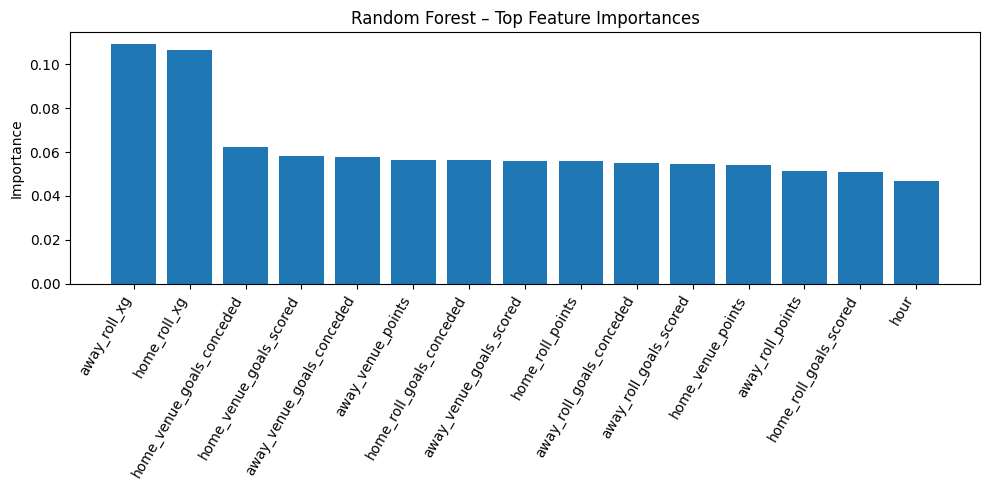

In [9]:
import matplotlib.pyplot as plt

top_n = 15
top_fi = fi_rf.head(top_n)

plt.figure(figsize=(10, 5))
plt.bar(top_fi["feature"], top_fi["importance"])
plt.xticks(rotation=60, ha="right")
plt.ylabel("Importance")
plt.title("Random Forest – Top Feature Importances")
plt.tight_layout()
plt.show()


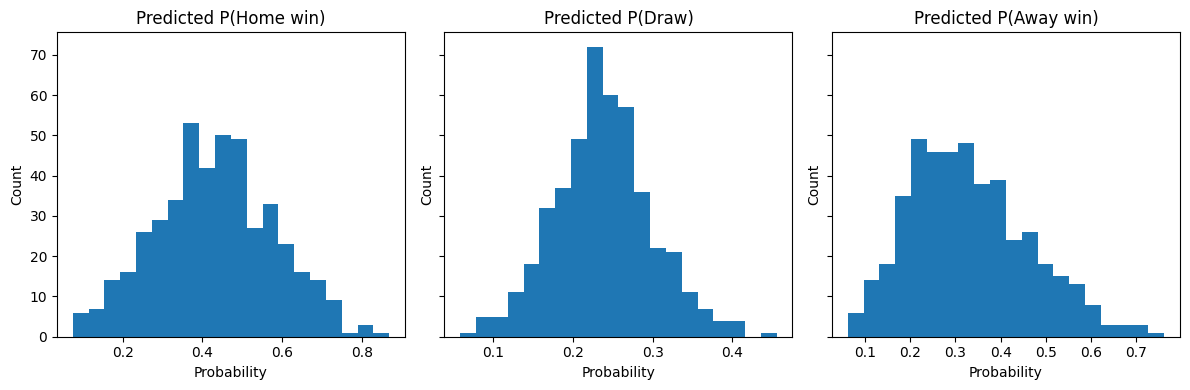

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

axes[0].hist(proba_df["prob_home"], bins=20)
axes[0].set_title("Predicted P(Home win)")

axes[1].hist(proba_df["prob_draw"], bins=20)
axes[1].set_title("Predicted P(Draw)")

axes[2].hist(proba_df["prob_away"], bins=20)
axes[2].set_title("Predicted P(Away win)")

for ax in axes:
    ax.set_xlabel("Probability")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


In [11]:
sample_idx = proba_df.sample(10, random_state=42).index

example_preds = (
    proba_df.loc[sample_idx]
    .assign(true_outcome=y_test.loc[sample_idx].values)
)

example_preds


,prob_away,prob_draw,prob_home,true_outcome
790,0.153329,0.200825,0.645846,home
1663,0.318754,0.221746,0.459500,away
1976,0.365820,0.255290,0.378890,draw
779,0.507373,0.277767,0.214860,away
1929,0.289422,0.251896,0.458683,home
791,0.128739,0.138917,0.732344,draw
1183,0.192270,0.264864,0.542866,home
1444,0.286575,0.248873,0.464552,home
223,0.292602,0.251364,0.456034,home
1617,0.422476,0.191873,0.385651,home


XGB:

In [ ]:
result_xgb = train_match_outcome_model(
    data_path=DATA_PATH,
    model_type="xgb",
    test_size=0.2,
    random_state=42,
)

result_xgb.keys()

In [ ]:
metrics_xgb = result_xgb["metrics"]

print("=== XGBoost performance ===")
print(f"Accuracy:  {metrics_xgb['accuracy']:.4f}")
print(f"Log loss:  {metrics_xgb['log_loss']:.4f}")
print("\nClassification report:")
print(metrics_xgb["classification_report"])

In [ ]:
fi_xgb = result_xgb["feature_importances"]
fi_xgb.head(20)

In [ ]:
model_xgb = result_xgb["model"]
X_test_xgb = result_xgb["X_test"]
y_test_xgb = result_xgb["y_test"]

proba_xgb = model_xgb.predict_proba(X_test_xgb)
proba_xgb.head()
proba_xgb.describe()

In [ ]:
# Top features
top_n = 15
top_fi_xgb = fi_xgb.head(top_n)

plt.figure(figsize=(10, 5))
plt.bar(top_fi_xgb["feature"], top_fi_xgb["importance"])
plt.xticks(rotation=60, ha="right")
plt.ylabel("Importance")
plt.title("XGBoost – Top Feature Importances")
plt.tight_layout()
plt.show()

In [ ]:
# Probability histograms
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

axes[0].hist(proba_xgb_df["prob_home"], bins=20)
axes[0].set_title("XGB: P(Home win)")

axes[1].hist(proba_xgb_df["prob_draw"], bins=20)
axes[1].set_title("XGB: P(Draw)")

axes[2].hist(proba_xgb_df["prob_away"], bins=20)
axes[2].set_title("XGB: P(Away win)")

for ax in axes:
    ax.set_xlabel("Probability")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

In [ ]:
sample_idx_xgb = proba_xgb_df.sample(10, random_state=42).index

example_preds_xgb = (
    proba_xgb_df.loc[sample_idx_xgb]
    .assign(true_outcome=y_test_xgb.loc[sample_idx_xgb].values)
)

example_preds_xgb

## Model Evaluation & Performance

The Random Forest classifier was evaluated on a 20% hold-out test set using accuracy and log-loss as performance metrics. The model achieved an accuracy of approximately 0.59, indicating a clear improvement over random guessing and simple heuristic baselines such as predicting the majority class. The log-loss of ~0.99 suggests that the predicted probabilities are informative rather than arbitrarily confident.

Class-level analysis reveals notable asymmetry across outcomes. Home wins are predicted with relatively high recall (approximately 0.75), reflecting the strong home-field advantage present in the EPL. Away wins are identified with moderate accuracy, while draws remain the most challenging outcome, exhibiting substantially lower precision and recall. This difficulty is expected due to the lower frequency and inherent randomness of draws in football match outcomes.

## Feature Importance & Interpretability

Feature importance analysis indicates that the model relies primarily on recent underlying performance metrics. The most influential features are rolling expected goals for both teams (home_roll_xg, away_roll_xg), followed by venue-specific indicators such as goals scored, goals conceded, and points accumulated when playing at home or away.

These results confirm that chance quality and recent form are key drivers of match outcomes, while contextual variables such as rest-day differences and match timing (rest_days_diff, day_code, hour) contribute to a lesser degree. Overall, the model’s behavior aligns well with established football analytics insights and supports interpretability for non-technical users.

## Probability-Based Predictions

In addition to categorical predictions, the model outputs full probability distributions for home wins, draws, and away wins. The predicted probability histograms demonstrate clear asymmetry: home wins receive the highest average predicted probability (approximately 0.44), followed by away wins (~0.33) and draws (~0.24).

The distributions show that the model rarely assigns extreme probabilities (e.g., above 0.9), indicating appropriate uncertainty handling in a highly stochastic domain. Draw probabilities are more narrowly distributed and rarely dominate, which explains the weaker predictive performance for this class. These probabilistic outputs enable richer analysis, such as identifying uncertain fixtures or comparing predicted probabilities against external benchmarks.

## Qualitative Examples

Examination of individual test-set predictions further illustrates the model’s behavior. In matches where one outcome is strongly favored (e.g., predicted home win probability above 0.7), the prediction is often correct. Conversely, misclassifications tend to occur in matches where predicted probabilities are more evenly distributed across outcomes, highlighting genuine uncertainty rather than model error.

## Limitations & Future Work

The model does not incorporate player injuries, tactical adjustments, or transfer activity, which may have a significant impact on match outcomes. Additionally, draw prediction remains a limitation due to class imbalance and the inherent volatility of such results. Future work could involve hyperparameter tuning, evaluation of alternative models such as XGBoost, and the inclusion of richer contextual or player-level features to improve calibration and predictive performance.